# 吞咽障礙檢測 - 完整信號處理流程

本notebook實現了從原始RF信號到特徵提取的完整處理流程，用於吞咽障礙檢測。


## Block 1：Setup and data import


In [1]:
# ================================================================= #
# Block 1: Setup and data import
# ================================================================= #

# --- Step 0: Set Python search path ---
import sys
import os
# Add the folder containing the nearpy package to Python's search path
sys.path.insert(0, os.path.abspath('../nearpy'))

# --- Step 1: Import all required tools ---
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Import all modules from the nearpy library
from nearpy import *


# Display figures directly in the notebook
# Display figures directly in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['text.usetex'] = False 
print("✅ All tools imported successfully!")

c:\Users\USER\anaconda3\envs\NFS\Lib\site-packages\tsfresh\__init__.py:12: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


✅ All tools imported successfully!


In [2]:
import h5py
import pandas as pd
import numpy as np
from pathlib import Path

# --- Step 2: Create a helper function to read .h5 files ---
def read_h5_data(file_path):
    """
    Reads data from an HDF5 (.h5) file and returns a dictionary of numpy arrays.
    """
    try:
        data_dict = {}
        with h5py.File(file_path, 'r') as hf:
            # Assume the data is stored within a group named 'rf'
            if 'rf' in hf:
                for key in hf['rf'].keys():
                    if isinstance(hf['rf'][key], h5py.Dataset):
                        data_dict[key] = hf['rf'][key][:]
            else: # Otherwise, read directly from the root directory
                for key in hf.keys():
                    if isinstance(hf[key], h5py.Dataset):
                        data_dict[key] = hf[key][:]
        
    
        # Return the dictionary itself, not a DataFrame
        if not data_dict:
            print(f"  > Warning: No datasets found in {file_path.name}")
            return None
        return data_dict 
        
    except Exception as e:
        # file_path is now a Path object, use .name to get the filename
        print(f"!!! Error reading file {file_path.name}: {e} !!!")
        return None

# --- Step 3: Set the folder path and read "all" .h5 files ---

# Set the folder path to scan
data_folder_path = Path('D:/bioview/tiptoe/Original_data/0911')

# Search for all .h5 files in the folder
file_paths_list = list(data_folder_path.glob('*.h5'))

# Create a dictionary to store all the read data
# The format will be: {'filename': dictionary_of_arrays, ...}
all_rf_data = {}

if not file_paths_list:
    # --- If "no" .h5 files are found in the folder ---
    print(f"❌ No .h5 files found in {data_folder_path}.")

else:
    # --- If .h5 files "are" found ---
    print(f"✅ Found {len(file_paths_list)} .h5 files in {data_folder_path}. Starting to read...")
    
    for file_path in file_paths_list:
        
        # Read a single file
        # 'data_content' is now a dictionary of arrays, NOT a DataFrame
        data_content = read_h5_data(file_path)
        
        if data_content is not None:
            # Use .stem to get the filename without the extension
            file_key = file_path.stem 
            
            # Store the read dictionary into the main dictionary
            all_rf_data[file_key] = data_content

        else:
            print(f"  > ❌ Failed to read or data is empty: {file_path.name}")

# --- Step 4: (New) Display a summary of the read data ---
print("\n--- Reading complete ---")

# Check if the all_rf_data dictionary is empty
if all_rf_data:
    print(f"Successfully loaded data from {len(all_rf_data)} files.")
    print(f"Available data keys (filenames): {list(all_rf_data.keys())}")
    
    # Example: Access one of the data entries (e.g., the first one)
    first_key = list(all_rf_data.keys())[0]
    first_data_dict = all_rf_data[first_key]
    
    print(f"\n--- Displaying summary for the first data entry '{first_key}' ---")
    print(f"  Found {len(first_data_dict.keys())} datasets:")
    
    # Print the keys and shapes of the arrays found in this file's dictionary
    for dataset_name, data_array in first_data_dict.items():
        print(f"    - Dataset '{dataset_name}' with shape: {data_array.shape}")

else:
    # If the dictionary is empty (no files found, or all files failed to read)
    print("❌ No data was loaded in the end.")

✅ Found 22 .h5 files in D:\bioview\tiptoe\Original_data\0911. Starting to read...

--- Reading complete ---
Successfully loaded data from 22 files.
Available data keys (filenames): ['0911_Alex_rest_test', '0911_Alex_stand10', '0911_Alex_stand6', '0911_Alex_stand7', '0911_Alex_stand8', '0911_Alex_stand9', '0911_alex_stand_test1', '0911_alex_stand_test2', '0911_alex_stand_test3', '0911_alex_stand_test4', '0911_alex_stand_test5', '0911_Alex_swallow_test', '0911_Jessie_stand1', '0911_Jessie_stand10', '0911_Jessie_stand2', '0911_Jessie_stand3', '0911_Jessie_stand4', '0911_Jessie_stand5', '0911_Jessie_stand6', '0911_Jessie_stand7', '0911_Jessie_stand8', '0911_Jessie_stand9']

--- Displaying summary for the first data entry '0911_Alex_rest_test' ---
  Found 1 datasets:
    - Dataset 'data' with shape: (8, 334560)


In [3]:
import pandas as pd # 確保你已經 import pandas

# --- Step 5: (New) Create a simplified dictionary and convert to DataFrame ---
# 我們來建立一個更簡單的字典：
# {'filename': pandas_dataframe}

print("\n--- Creating simplified 'data' dictionary (and converting to DataFrame) ---")

raw_data = {}

for file_key, inner_dict in all_rf_data.items():
    
    # 檢查 'data' 這個 dataset 是否存在於該檔案的字典中
    if 'data' in inner_dict:
        
        # 1. 取得 NumPy 陣列，shape 可能是 (8, 334560)
        data_array = inner_dict['data']
        
        # 2. 檢查維度，確保是 2D
        if data_array.ndim != 2:
            print(f"  > Warning: Dataset 'data' in {file_key} is not 2D (shape: {data_array.shape}). Skipping.")
            continue
            
        # 3. --- 關鍵步驟：轉置 (Transpose) ---
        #    將 (channels, samples) 轉為 (samples, channels)
        #    (8, 334560) -> (334560, 8)
        #    如果你的資料 *已經* 是 (samples, channels)，請移除 .T
        data_transposed = data_array.T
        
        # 4. (可選, 但推薦) 根據轉置後的 shape 建立欄位名稱
        num_channels = data_transposed.shape[1]
        channel_cols = [f"Ch{i+1}" for i in range(num_channels)]
        
        # 5. 轉換為 DataFrame 並存入新字典
        raw_data[file_key] = pd.DataFrame(data_transposed, columns=channel_cols)
        
    else:
        # 如果有檔案缺失了 'data'，就印出警告
        print(f"  > Warning: Dataset 'data' not found in file '{file_key}'")


if raw_data:
    print(f"\n✅ Successfully created simplified dictionary with {len(raw_data)} entries.")
    print(f"Keys (filenames): {list(raw_data.keys())}")
    
    # 顯示第一個檔案的 'data' 陣列 shape
    first_key = list(raw_data.keys())[0]
    
    # 這裡的 Shape 輸出現在會是 (334560, 8)
    print(f"  - Shape of 'data' from '{first_key}' (as DataFrame): {raw_data[first_key].shape}")
    
    # 你也可以印出 DataFrame 的表頭來確認
    print("  - Head of first DataFrame:")
    print(raw_data[first_key].head())
    
else:
    print("❌ Could not create simplified dictionary (no 'data' datasets found).")


--- Creating simplified 'data' dictionary (and converting to DataFrame) ---

✅ Successfully created simplified dictionary with 22 entries.
Keys (filenames): ['0911_Alex_rest_test', '0911_Alex_stand10', '0911_Alex_stand6', '0911_Alex_stand7', '0911_Alex_stand8', '0911_Alex_stand9', '0911_alex_stand_test1', '0911_alex_stand_test2', '0911_alex_stand_test3', '0911_alex_stand_test4', '0911_alex_stand_test5', '0911_Alex_swallow_test', '0911_Jessie_stand1', '0911_Jessie_stand10', '0911_Jessie_stand2', '0911_Jessie_stand3', '0911_Jessie_stand4', '0911_Jessie_stand5', '0911_Jessie_stand6', '0911_Jessie_stand7', '0911_Jessie_stand8', '0911_Jessie_stand9']
  - Shape of 'data' from '0911_Alex_rest_test' (as DataFrame): (334560, 8)
  - Head of first DataFrame:
        Ch1       Ch2       Ch3       Ch4       Ch5       Ch6       Ch7  \
0 -0.009656  0.003216 -0.020781  0.022639  0.007464  0.001748 -0.003836   
1 -0.013137  0.000162  0.001790  0.034934  0.010813  0.000280 -0.003545   
2 -0.013084  0.0

In [4]:
#####Question: 不確定這樣的TxRx順序是否正確
import math
from nearpy.utils import mimo as mimo_utils

# --- Step 6 Combined: Process and Name MIMO Datasets ---
print("\n" + "=" * 70)
print("Processing 8-Channel Datasets with MIMO Organization and Naming")
print("=" * 70)

raw_data_mimo = {}

# 我們假設 'data' 是一個 (samples, channels) 格式的 DataFrame
for file_key, data in raw_data.items():
    
    df = data.copy()  # 避免修改原始 data
    
    # 1. 取得基本資訊
    original_channel_names = list(df.columns)
    num_channels = df.shape[1]

    # 2. 預設值 (如果命名失敗，將使用這些)
    channel_names = original_channel_names
    mimo_layout = None
    
    # --- 嘗試套用 MIMO 命名邏輯 (來自您的第二個程式碼片段) ---
    if num_channels == 8: # 我們可以更嚴格地只檢查 8 欄
        half = num_channels // 2 # half = 4
        n_mimo = 2
        
        # 檢查是否為 2x2 MIMO (2*2 = 4) 且有 mag/phase (4*2 = 8 cols)
        if (n_mimo * n_mimo == half):
            
            # 強制交錯命名: (mag,phase)
            names = []
            for i in range(num_channels):
                base = mimo_utils.TxRx(i // 2, n_mimo)
                suffix = '_mag' if (i % 2) == 0 else '_phase'
                names.append(base + suffix)

            try:
                # 成功：更新 DataFrame 的欄位和我們的最終名稱列表
                df.columns = names
                final_channel_names = names
                mimo_layout = {'n_mimo': n_mimo, 'paired': True, 'layout': 'interleaved'}
                
            except Exception as e:
                print(f"  > Failed to set paired columns for {file_key}: {e}")
                # 失敗，名稱將保持為 'original_channel_names'
        else:
            print(f"  > File {file_key}: Has {num_channels} cols, but not a 2x2 MIMO mag/phase layout. Using default names.")
    else:
        print(f"  > File {file_key}: Has {num_channels} cols (not 8). Using default names.")

    # 3. 建立最終的 MIMO 字典條目
    mimo_data = {
        'num_channels': num_channels,
        'channel_names': channel_names, # 儲存最終的 (可能是新的) 名稱
        'dataframe': df,                      # 儲存 (可能是) 重新命名的 DataFrame
        'num_samples': len(df),
        'mimo_layout': mimo_layout            # 儲存 MIMO 佈局資訊
    }

    raw_data_mimo[file_key] = mimo_data

# --- 最終摘要---
print("\n" + "=" * 70)
print(f"✅ 8-Channel MIMO Processing & Naming Completed!")
print(f"   Total files processed: {len(raw_data_mimo)}")

# 檢查是否有任何資料被處理，以避免 'first_key' 錯誤
if raw_data_mimo:
    first_key = list(raw_data_mimo.keys())[0]
    print("  - Head of first DataFrame (channel names):")
    try:
        print(raw_data_mimo[first_key]['channel_names'])
        print("  - DataFrame head:")
        print(raw_data_mimo[first_key]['dataframe'].head())
    except Exception as e:
        print(f"  > Could not print DataFrame info for '{first_key}': {e}")
else:
    print("  > No data was processed.")
    
print("=" * 70)


Processing 8-Channel Datasets with MIMO Organization and Naming

✅ 8-Channel MIMO Processing & Naming Completed!
   Total files processed: 22
  - Head of first DataFrame (channel names):
['Ch1', 'Ch2', 'Ch3', 'Ch4', 'Ch5', 'Ch6', 'Ch7', 'Ch8']
  - DataFrame head:
   Tx1Rx1_mag  Tx1Rx1_phase  Tx2Rx1_mag  Tx2Rx1_phase  Tx1Rx2_mag  \
0   -0.009656      0.003216   -0.020781      0.022639    0.007464   
1   -0.013137      0.000162    0.001790      0.034934    0.010813   
2   -0.013084      0.000275    0.001091      0.034549    0.010699   
3   -0.013047      0.000276    0.001077      0.034565    0.010732   
4   -0.013062      0.000262    0.001125      0.034536    0.010697   

   Tx1Rx2_phase  Tx2Rx2_mag  Tx2Rx2_phase  
0      0.001748   -0.003836      0.064692  
1      0.000280   -0.003545      0.090026  
2      0.000336   -0.003715      0.089425  
3      0.000306   -0.003677      0.089444  
4      0.000316   -0.003655      0.089452  


## Block 2: Display raw signal (Raw Data)


findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times


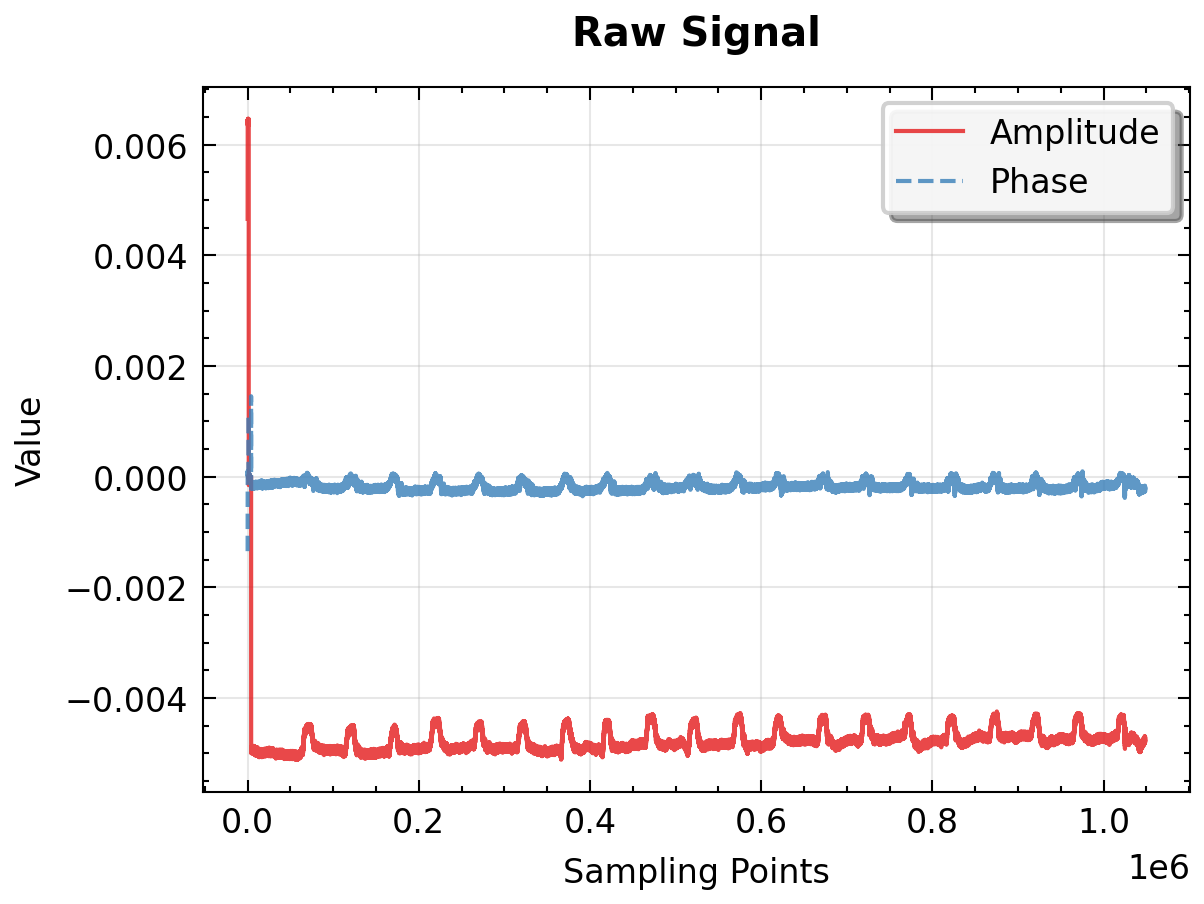

In [5]:
from nearpy.plots import plot_time_series
import numpy as np
rf_entry = raw_data_mimo.get('0911_Alex_stand10')
if rf_entry is not None:
    rf_data = rf_entry.get('dataframe')
    if rf_data is not None and not rf_data.empty:
        mag_channel = 'Tx1Rx1_mag'
        phase_channel = 'Tx1Rx1_phase'
        if mag_channel in rf_data.columns and phase_channel in rf_data.columns:
            raw_mag_signal = rf_data[mag_channel].values
            raw_phase_signal = rf_data[phase_channel].values
            plot_dict = {
                "Raw Signal": {
                    "Amplitude": raw_mag_signal,
                    "Phase": raw_phase_signal,
                    "time_axis": np.arange(len(raw_mag_signal)),
                    "xlabel": "Sampling Points",
                    "ylabel": "Value"
                }
            }
            fig, axes = plot_time_series(plot_dict)
        else:
            print(f"❌ Cannot find specified channels: {mag_channel}, {phase_channel}")
            print("Available channels:", rf_data.columns.tolist())
    else:
        print("❌ No data available in DataFrame")
else:
    print("❌ No entry found for '0911_Alex_rest_test' in raw_data_mimo")

## 區塊 3：訊號濾波 (Filtering)


In [6]:
# ================================================================= #
# Block: Filter all signals for every entry in `raw_data_mimo` (using spike removal + ncs_filt)
# ================================================================= #
from nearpy.preprocess.filters import spike_removal_filter, ncs_filt
import pandas as pd
import numpy as np

def _choose_n_taps(sig_len, fs):
    # Heuristic: desire filter length ~ 0.5-4 seconds of data depending on fs, but not exceed signal length-1
    desired = int(min(4 * fs, max(3, 0.5 * fs)))
    # ensure odd and < sig_len
    desired = max(3, int(desired))
    if desired >= sig_len:
        desired = sig_len - 1
    if desired % 2 == 0:
        desired -= 1
    if desired < 3:
        desired = 3
    return desired

def filter_all_signals(raw_data_mimo, fs=1000, f_p=0.3, f_s=10, ftype='bandpass', detrend_deg=None):
    """
    Apply spike removal + NCS FIR filtering to every channel in every entry of `raw_data_mimo`.
    - raw_data_mimo: dict mapping filename -> dict with at least key 'dataframe' (pandas.DataFrame)
    - fs: sampling frequency (Hz)
    - f_p: lower pass (used by `ncs_filt` to set transitions)
    - f_s: upper pass-band frequency (Hz) passed to `ncs_filt`
    - ftype: filter type string passed to `ncs_filt` ('bandpass','lowpass','highpass','bandass')
    - detrend_deg: if provided, polynomial detrending degree will be applied before other steps (keeps API similar)
    Returns the same dict with an added key 'filtered_dataframe' in each entry.
    """
    for key, entry in raw_data_mimo.items():
        df = entry.get('dataframe')
        if df is None or df.empty:
            print(f"Skipping '{key}': no dataframe available")
            continue
        # Prepare output DataFrame with same index/columns
        filt_df = pd.DataFrame(index=df.index, columns=df.columns, dtype=float)
        for col in df.columns:
            sig = df[col].values.astype(float)
            try:
                # 0) optional detrend (keeps compatibility)
                if detrend_deg is not None:
                    from nearpy.preprocess.filters import detrend
                    sig = detrend(sig, deg=detrend_deg)
                # 1) spike removal (median + derivative smoothing)
                sig_spiked = spike_removal_filter(sig, fs)
                # 2) choose n_taps heuristically based on length and fs
                n_taps = _choose_n_taps(len(sig_spiked), fs)
                # 3) apply NCS filter (zero-phase inside ncs_filt via filtfilt)
                sig_f = ncs_filt(sig_spiked, n_taps=n_taps, f_p=f_p, f_s=f_s, fs=fs, ftype=ftype)
            except Exception as e:
                print(f"  > Warning: failed to filter {key}:{col} -> {e}. Falling back to original signal.")
                sig_f = sig
            filt_df[col] = sig_f
        # Store results back in the entry
        entry['filtered_dataframe'] = filt_df
        entry['filter_meta'] = {'fs': fs, 'f_p': f_p, 'f_s': f_s, 'ftype': ftype}
    print('✅ Filtering finished for all entries (spike removal + NCS filter).')
    return raw_data_mimo

# --- Run filtering with sensible defaults ---
raw_data_mimo = filter_all_signals(raw_data_mimo, fs=100, f_p=0.1, f_s=10, ftype='bandpass', detrend_deg=None)
# Show a quick sample summary
if raw_data_mimo:
    sample_key = list(raw_data_mimo.keys())[0]
    sample_entry = raw_data_mimo[sample_key]
    if 'filtered_dataframe' in sample_entry:
        print(f"Sample '{sample_key}' filtered columns:", sample_entry['filtered_dataframe'].columns.tolist())
        display(sample_entry['filtered_dataframe'].head())
    else:
        print(f"No 'filtered_dataframe' for sample '{sample_key}'")

✅ Filtering finished for all entries (spike removal + NCS filter).
Sample '0911_Alex_rest_test' filtered columns: ['Tx1Rx1_mag', 'Tx1Rx1_phase', 'Tx2Rx1_mag', 'Tx2Rx1_phase', 'Tx1Rx2_mag', 'Tx1Rx2_phase', 'Tx2Rx2_mag', 'Tx2Rx2_phase']


,Tx1Rx1_mag,Tx1Rx1_phase,Tx2Rx1_mag,Tx2Rx1_phase,Tx1Rx2_mag,Tx1Rx2_phase,Tx2Rx2_mag,Tx2Rx2_phase
0,3.308722e-24,2.019484e-27,0.000000e+00,-6.462349e-27,-6.462349e-27,6.462349e-27,1.902515e-23,1.009742e-27
1,1.464196e-07,2.691918e-12,1.437205e-18,3.365231e-11,6.472922e-12,9.886820e-12,1.492169e-07,3.952249e-13
2,2.946125e-07,3.392727e-12,2.419335e-18,4.232794e-11,8.141648e-12,1.243564e-11,3.006667e-07,9.044722e-14
3,4.281909e-07,5.105273e-13,2.572230e-18,6.060300e-12,1.165661e-12,1.780371e-12,4.187192e-07,-1.467544e-12
4,5.363852e-07,-6.828074e-12,1.669071e-18,-8.609987e-11,-1.656109e-11,-2.529580e-11,4.971872e-07,-4.568963e-12


20251117 to here 
Next = plot filtered data

## 區塊 4：訊號分段 (Segmentation) 與 樣板建立 (Template Creation)


In [ ]:
# ================================================================= #
# Block 4: Signal segmentation (Segmentation) and template creation (Template Creation)
# ================================================================= #

# We choose the filtered signal for further analysis
if 'mag_filtered' in locals():
    final_signal = mag_filtered
    
    print("Performing automatic segmentation on clean signal...")
    
    # Use adaptive segmentation method
    from nearpy.preprocess.segment import get_adaptive_segment_indices
    
    # Use moving standard deviation (Movstd) to automatically find motion segments
    segments_indices = get_adaptive_segment_indices(
        final_signal, 
        timeAx=np.linspace(0, len(final_signal)/fs, len(final_signal)),
        fs=fs,
        method='Movstd', 
        win_size=int(fs * 0.5),  # 0.5 second window
        prob_thresh=0.8  # Threshold
    )
    
    if len(segments_indices) > 0:
        num_segments = len(segments_indices)
        print(f"✅ Automatically detected {num_segments} motion segments in signal.")
        
        # Plot all detected segments to check segmentation quality
        print("Plotting segmentation results...")
        fig, ax = plt.subplots(figsize=(15, 6))
        
        # Plot filtered signal
        ax.plot(final_signal, label='Filtered Signal', alpha=0.7)
        
        # Mark segmentation regions
        for i, (start, end) in enumerate(segments_indices):
            ax.axvspan(start, end, alpha=0.3, color=f'C{i}', 
                      label=f'Segment {i+1}' if i < 5 else None)
        
        ax.set_title("Automatic segmentation results (Detected Segments)")
        ax.set_xlabel("Sampling Points")
        ax.set_ylabel("Amplitude")
        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        # Create motion template
        print("\nCreating motion template...")
        
        # 1. Extract waveforms for each motion segment from the signal
        signal_segments = []
        for start, end in segments_indices:
            segment = final_signal[start:end]
            if len(segment) > 10:  # Keep only segments with sufficient length
                signal_segments.append(segment)
        
        if len(signal_segments) > 0:
            print(f"Valid segments: {len(signal_segments)}")
            
            # 2. Since each segment may have different length, pad them to same length
            max_len = max(len(s) for s in signal_segments)
            padded_segments = np.array([np.pad(s, (0, max_len - len(s))) for s in signal_segments])
            
            # 3. Create template by simple averaging (simplified version, can use DTW in practice)
            template = np.mean(padded_segments, axis=0)
            
            print("✅ Template creation completed!")

            # Plot template and individual segments
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
            
            # Top plot: All segments
            for i, seg in enumerate(padded_segments[:5]):  # Show only first 5
                ax1.plot(seg, alpha=0.6, label=f'Segment {i+1}')
            ax1.set_title("Individual motion segments")
            ax1.set_ylabel("Amplitude")
            ax1.legend()
            ax1.grid(True, alpha=0.3)
            
            # Bottom plot: Average template
            ax2.plot(template, color='red', linewidth=2, label='Motion template')
            ax2.set_title("Average template for Tiptoe motion")
            ax2.set_xlabel("Aligned sampling points")
            ax2.set_ylabel("Normalized amplitude")
            ax2.legend()
            ax2.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
            
            # Save template for later use
            template_signal = template
        else:
            print("❌ No valid segments found")
    else:
        print("❌ No motion segments detected")
        # If automatic segmentation fails, manually create a simple template
        print("Using manual segmentation method...")
        # Divide signal into 3 segments as example
        segment_len = len(final_signal) // 3
        segments_indices = [(i*segment_len, (i+1)*segment_len) for i in range(3)]
        
        signal_segments = [final_signal[start:end] for start, end in segments_indices]
        max_len = max(len(s) for s in signal_segments)
        padded_segments = np.array([np.pad(s, (0, max_len - len(s))) for s in signal_segments])
        template_signal = np.mean(padded_segments, axis=0)
        
        print("✅ Manual template creation completed!")
else:
    print("❌ No filtered signal available")

❌ 沒有可用的濾波後信號


## 區塊 5：特徵提取 (Feature Extraction)


In [ ]:
# ================================================================= #
# Block 5: Feature extraction (Feature Extraction)
# ================================================================= #

if 'template_signal' in locals():
    print("Extracting features from template signal...")
    
    # Extract temporal features
    from nearpy.features.temporal import get_temporal_feats
    
    temporal_features = get_temporal_feats(template_signal)
    
    print("✅ Temporal feature extraction completed!")
    print("Extracted features:")
    for feat_name, feat_value in temporal_features.items():
        print(f"  {feat_name}: {feat_value:.4f}")
    
    # Extract frequency domain features
    from nearpy.preprocess.spectrum import ncs_fft
    
    # Compute frequency spectrum
    frequencies, power_spectrum = ncs_fft(template_signal, fs=fs)
    
    # Compute some frequency domain features
    dominant_freq = frequencies[np.argmax(power_spectrum)]
    spectral_energy = np.sum(power_spectrum)
    spectral_centroid = np.sum(frequencies * power_spectrum) / np.sum(power_spectrum)
    
    spectral_features = {
        'Dominant_Frequency': dominant_freq,
        'Spectral_Energy': spectral_energy,
        'Spectral_Centroid': spectral_centroid,
        'Peak_Power': np.max(power_spectrum)
    }
    
    print("\n✅ Frequency domain feature extraction completed!")
    print("Frequency domain features:")
    for feat_name, feat_value in spectral_features.items():
        print(f"  {feat_name}: {feat_value:.4f}")
    
    # Plot frequency spectrum
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Time domain signal and features
    ax1.plot(template_signal, label='Template Signal')
    ax1.set_title('Motion template (Time domain)')
    ax1.set_xlabel('Sampling point')
    ax1.set_ylabel('Amplitude')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Frequency domain signal
    ax2.plot(frequencies, power_spectrum)
    ax2.axvline(dominant_freq, color='red', linestyle='--', label=f'Dominant Freq: {dominant_freq:.2f} Hz')
    ax2.set_title('Power spectrum')
    ax2.set_xlabel('Frequency (Hz)')
    ax2.set_ylabel('Power')
    ax2.set_xlim(0, 20)  # Show only 0-20Hz range
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Combine all features
    all_features = {**temporal_features, **spectral_features}
    
    # Create features DataFrame
    features_df = pd.DataFrame([all_features])
    
    print("\n✅ All features extraction completed!")
    print("\nFeature summary:")
    print(features_df)
    
else:
    print("❌ No template signal available")

## 區塊 6：數據集創建與機器學習準備


In [ ]:
# ================================================================= #
# Block 6: Dataset creation and machine learning preparation
# ================================================================= #

print("Preparing machine learning dataset...")

# Create synthetic dataset for multiple motion classes
def create_synthetic_dataset():
    """Create synthetic dysphagia detection dataset"""
    
    # Define motion types
    gestures = {
        'rest': 0,      # Rest
        'swallow': 1,   # Swallow
        'tiptoe': 2     # Tiptoe
    }
    
    # Parameter settings
    fs = 100
    duration = 3  # 3 seconds per motion
    num_subjects = 3
    num_reps = 5  # 5 repetitions per motion
    
    dataset = []
    
    for subject in range(1, num_subjects + 1):
        for gesture_name, gesture_id in gestures.items():
            for rep in range(1, num_reps + 1):
                # Generate synthetic signal
                t = np.linspace(0, duration, int(fs * duration))
                
                if gesture_name == 'rest':
                    # Rest: Low frequency small amplitude oscillation
                    signal = 1.0 + 0.1 * np.sin(2 * np.pi * 0.2 * t) + 0.05 * np.random.randn(len(t))
                elif gesture_name == 'swallow':
                    # Swallow: Mid frequency larger amplitude oscillation
                    signal = 1.0 + 0.4 * np.sin(2 * np.pi * 1.5 * t) + 0.1 * np.random.randn(len(t))
                else:  # tiptoe
                    # Tiptoe: High frequency large amplitude oscillation
                    signal = 1.0 + 0.6 * np.sin(2 * np.pi * 3.0 * t) + 0.15 * np.random.randn(len(t))
                
                # Apply filtering
                filter_taps = get_gesture_filter(f_s=15, fs=fs, visualize=False)
                filtered_signal = filtfilt(filter_taps, 1, signal)
                
                # Extract features
                temporal_feats = get_temporal_feats(filtered_signal)
                frequencies, power_spectrum = ncs_fft(filtered_signal, fs=fs)
                
                # Simplified feature set
                features = {
                    'Mobility': temporal_feats['Mobility'],
                    'Complexity': temporal_feats['Complexity'],
                    'Energy': temporal_feats['Energy'],
                    'Dominant_Freq': frequencies[np.argmax(power_spectrum)],
                    'Spectral_Energy': np.sum(power_spectrum),
                    'Subject': subject,
                    'Gesture': gesture_name,
                    'Gesture_ID': gesture_id,
                    'Repetition': rep
                }
                
                dataset.append(features)
    
    return pd.DataFrame(dataset)

# Create dataset
ml_dataset = create_synthetic_dataset()

print(f"✅ Dataset creation completed!")
print(f"Dataset shape: {ml_dataset.shape}")
print(f"Motion classes included: {ml_dataset['Gesture'].unique()}")
print(f"Subjects included: {ml_dataset['Subject'].unique()}")

# Display first few rows of dataset
print("\nFirst 5 rows of dataset:")
print(ml_dataset.head())

# Statistical information
print("\nSample count for each motion class:")
print(ml_dataset['Gesture'].value_counts())

# Visualize feature distribution
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

feature_cols = ['Mobility', 'Complexity', 'Energy', 'Dominant_Freq']

for i, feature in enumerate(feature_cols):
    for gesture in ml_dataset['Gesture'].unique():
        data = ml_dataset[ml_dataset['Gesture'] == gesture][feature]
        axes[i].hist(data, alpha=0.6, label=gesture, bins=10)
    
    axes[i].set_title(f'{feature} distribution')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 區塊 7：簡單分類器演示


In [ ]:
# ================================================================= #
# 區塊 7: 簡單分類器演示
# ================================================================= #

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns

print("正在訓練簡單的分類器...")

# 準備特徵和標籤
feature_cols = ['Mobility', 'Complexity', 'Energy', 'Dominant_Freq', 'Spectral_Energy']
X = ml_dataset[feature_cols]
y = ml_dataset['Gesture_ID']

# 標準化特徵
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 分割數據集
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

print(f"訓練集大小: {X_train.shape}")
print(f"測試集大小: {X_test.shape}")

# 訓練隨機森林分類器
rf_classifier = RandomForestClassifier(
    n_estimators=100, 
    random_state=42, 
    max_depth=5
)

rf_classifier.fit(X_train, y_train)

# 預測
y_pred = rf_classifier.predict(X_test)

# 評估
accuracy = accuracy_score(y_test, y_pred)
print(f"\n✅ 分類器訓練完成！")
print(f"測試準確率: {accuracy:.3f}")

# 詳細分類報告
gesture_names = ['rest', 'swallow', 'tiptoe']
print("\n分類報告:")
print(classification_report(y_test, y_pred, target_names=gesture_names))

# 混淆矩陣
cm = confusion_matrix(y_test, y_pred)

# 繪製混淆矩陣
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=gesture_names, yticklabels=gesture_names)
plt.title('混淆矩陣 (Confusion Matrix)')
plt.xlabel('預測標籤')
plt.ylabel('真實標籤')
plt.show()

# 特徵重要性
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_classifier.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n特徵重要性:")
print(feature_importance)

# 繪製特徵重要性
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='Importance', y='Feature')
plt.title('特徵重要性 (Feature Importance)')
plt.xlabel('重要性')
plt.tight_layout()
plt.show()

print("\n🎉 完整信號處理流程演示完成！")
print("\n總結:")
print("1. ✅ 成功讀取和可視化原始RF信號")
print("2. ✅ 應用帶通濾波器去除噪聲")
print("3. ✅ 進行信號分段和樣板建立")
print("4. ✅ 提取時域和頻域特徵")
print("5. ✅ 創建機器學習數據集")
print("6. ✅ 訓練分類器並評估性能")
print("\n這個流程為吞咽障礙檢測提供了完整的信號處理基礎！")


  > Warning: failed to filter 0911_Alex_rest_test:Tx1Rx1_mag -> no footprint or filter size provided. Falling back to original signal.
  > Warning: failed to filter 0911_Alex_rest_test:Tx1Rx1_phase -> no footprint or filter size provided. Falling back to original signal.
  > Warning: failed to filter 0911_Alex_rest_test:Tx2Rx1_mag -> no footprint or filter size provided. Falling back to original signal.
  > Warning: failed to filter 0911_Alex_rest_test:Tx2Rx1_phase -> no footprint or filter size provided. Falling back to original signal.
  > Warning: failed to filter 0911_Alex_rest_test:Tx1Rx2_mag -> no footprint or filter size provided. Falling back to original signal.
  > Warning: failed to filter 0911_Alex_rest_test:Tx1Rx2_phase -> no footprint or filter size provided. Falling back to original signal.
  > Warning: failed to filter 0911_Alex_rest_test:Tx2Rx2_mag -> no footprint or filter size provided. Falling back to original signal.
  > Warning: failed to filter 0911_Alex_rest_test

  > Warning: failed to filter 0911_Alex_rest_test:Tx1Rx1_mag -> no footprint or filter size provided. Falling back to original signal.
  > Warning: failed to filter 0911_Alex_rest_test:Tx1Rx1_phase -> no footprint or filter size provided. Falling back to original signal.
  > Warning: failed to filter 0911_Alex_rest_test:Tx2Rx1_mag -> no footprint or filter size provided. Falling back to original signal.
  > Warning: failed to filter 0911_Alex_rest_test:Tx2Rx1_phase -> no footprint or filter size provided. Falling back to original signal.
  > Warning: failed to filter 0911_Alex_rest_test:Tx1Rx2_mag -> no footprint or filter size provided. Falling back to original signal.
  > Warning: failed to filter 0911_Alex_rest_test:Tx1Rx2_phase -> no footprint or filter size provided. Falling back to original signal.
  > Warning: failed to filter 0911_Alex_rest_test:Tx2Rx2_mag -> no footprint or filter size provided. Falling back to original signal.
  > Warning: failed to filter 0911_Alex_rest_test

,Tx1Rx1_mag,Tx1Rx1_phase,Tx2Rx1_mag,Tx2Rx1_phase,Tx1Rx2_mag,Tx1Rx2_phase,Tx2Rx2_mag,Tx2Rx2_phase
0,-0.009656,0.003216,-0.020781,0.022639,0.007464,0.001748,-0.003836,0.064692
1,-0.013137,0.000162,0.001790,0.034934,0.010813,0.000280,-0.003545,0.090026
2,-0.013084,0.000275,0.001091,0.034549,0.010699,0.000336,-0.003715,0.089425
3,-0.013047,0.000276,0.001077,0.034565,0.010732,0.000306,-0.003677,0.089444
4,-0.013062,0.000262,0.001125,0.034536,0.010697,0.000316,-0.003655,0.089452
